### Dota2 Application

This is a continuation of my other project, the Dota2 win predictor. Here I am going to do some light web scraping to gather some more data and incorporate a couple more features into an app that can give hero suggestions as well as the predict the winner of a match at a specific time.

In [40]:
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import re
from selenium.webdriver.support.ui import WebDriverWait
import time 
import matplotlib.pyplot as plt

#dependencies for class object that is being loaded
import pandas as pd
from pandas.api.types import is_numeric_dtype
import scipy.stats as ss
from scipy.special import boxcox1p  

Opening chrome to the desired webpage.

In [2]:
options = Options()
options.headless = True
options.add_argument('--window-size=1920,1200')

DRIVER_PATH = 'C:/Users/JT/Desktop/Data Science/chromedriver_win32/chromedriver.exe'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)
driver.get('https://www.dotabuff.com/heroes')


Here is where I will start scraping from the website to get the counters for each hero.

In [3]:
#get html from dotabuff website
soup = BeautifulSoup(driver.page_source)

#find all the hero names located on the page
soup_heroes = soup.find_all('div', attrs = {'class':'name'})
hero_names = []

#extract the hero names from the soup
for item in range(len(soup_heroes)):
    hero_names.append(str(soup_heroes[item])[18:-6])

#replace spaces with hyphens
hero_names = [s.replace(" ", "-") for s in hero_names]

#replace apostrophe with nothing
hero_names = [s.replace("'", "") for s in hero_names]

Navigating to the pages that contain hero counters.

In [4]:
counter_list = []

#loop over all the hero names
for hero in hero_names:    
    #navigating to the page with the counter information
    driver.get('https://www.dotabuff.com/heroes')
    driver.find_element_by_xpath("//a[@href='/heroes/"+hero.lower()+"']").click()
    driver.find_element_by_xpath("//a[@href='/heroes/"+hero.lower()+"/counters']").click()
    time.sleep(5)
    
    #get the element for the disadvantage % against the hero
    elements_disadvantage = driver.find_elements_by_class_name('sorted')
    
    #get element for the counter hero name
    elements_hero = driver.find_elements_by_class_name('cell-icon')

    for element in range(len(elements_hero)):
        #loop through the element items to get the individual hero names and counter %
        counter_hero = elements_hero[element].get_attribute('data-value') 
        disadvantage = elements_disadvantage[element+1].get_attribute('data-value') 

        
        counter_list.append([hero, counter_hero, disadvantage])
        
#dataframe of counter 
counter_df = pd.DataFrame(counter_list, columns=['Hero', 'Counter', 'Disadvantage']).set_index(['Hero','Counter'])

#Exit
driver.quit()

#### Interactive Application

I'm going to make a custom class where all the needed functions for the interface will be.

In [52]:
class dota_app:
     
    def __init__(self):
        from joblib import dump, load
        import dill
    
        self.counter_df = counter_df #is this best/OK practice?
        self.win_model = load('dota2_rfc.joblib')
        self.scale_model = load('robust_scaler.joblib')
        self.transform_model = None
        

        with open('boxcox_transform.pkl', 'rb') as in_strm:
             self.transform_model = dill.load(in_strm)
        
            
    def hero_counter(self, player1, player2='', player3='', player4='', player5=''):
        num_players = 0
        player_list = [player1, player2, player3, player4, player5]
        counter_df_names = ['hero_counter1','hero_counter2','hero_counter3','hero_counter4','hero_counter5']
        
        #get the number of heroes entered
        for item in player_list:
            if item != '':
                num_players +=1
        
        #create dictionary of dataframes that contain counters for each hero
        counter_dict = {counter_df_names[i]:pd.DataFrame() for i in range(num_players)}        
        
        for j in range(num_players):
            #get counters of the specified hero
            counter_mask = self.counter_df.index.get_level_values(0) == player_list[j]
            hero_counter_df = counter_dict['hero_counter'+str(j+1)] 
            hero_counter_df= self.counter_df[counter_mask]
            hero_counter_df.reset_index(inplace=True)
            
            #append hero number to columns (used to distinguish columns after pd.concat later)
            hero_counter_df.columns = hero_counter_df.columns+str(j+1) 
            hero_counter_df.set_index(['Hero'+str(j+1), 'Counter'+str(j+1)])        
        
            #putting the dataframe back in the dict
            counter_dict['hero_counter'+str(j+1)] = hero_counter_df
            
        #concatenate each dataframe
        all_counters = pd.DataFrame()

        for value in counter_dict.values():
            all_counters = pd.concat([all_counters, value], axis=1)

        #sort the dataframes from best counter to worst counter
        sort_cols = [col for col in all_counters if col.startswith('Disadv')]    
        counter_cols = [col for col in all_counters if col.startswith('Counter')]
        all_counters.sort_values(sort_cols)
        
        #change column names to be the hero that is being countered
        all_counters = all_counters[counter_cols][:10]
        all_counters.columns = player_list[:num_players]
        all_counters.columns = all_counters.columns + ' Counters:'
        
        return all_counters

    def win(self, rad_gold, rad_win_heroes, rad_level, rad_kills, rad_deaths,
                                dire_gold, dire_win_heroes, dire_level, dire_kills, dire_deaths):
        
        #make variables in terms of radiant advantage
        gold = float(rad_gold) - float(dire_gold)
        win_heroes = float(rad_win_heroes) - float(dire_win_heroes)
        level = float(rad_level) - float(dire_level)
        deaths = float(rad_deaths) - float(dire_deaths)
        kills = float(rad_kills) - float(dire_kills)
        
        input_array = np.array([gold, win_heroes, level, deaths, kills]).reshape(-1,5)
        
        input_df = pd.DataFrame(input_array)
        
        input_df = self.transform_model.positive_data(input_df)
        input_df = self.transform_model.transform(input_df)
        
        input_df = self.scale_model.transform(input_df)
        
        
        win_prediction = self.win_model.predict(input_df)
        
        if win_prediction == 1:
            win_team = 'Radiant'
        else:
            win_team = 'Dire'
        
        return win_team
    

As seen in my other notebook, the amount of gold a team has is the most important predictor of who will win the game. Therefore, instead of looking at what the best counter would be for the entire team, it would be more important to look at the counter for your lane so you can get the most last hits (and therefore the most gold).

Let's move on to making it interactive.

In [14]:
from tkinter import *
from tkinter import ttk


class dota_gui(Tk):
    
    def __init__(self, parent):
        self.button_count1 = 0
        self.button_count2 = 0
        
        self.parent = parent 
        
        self.my_notebook = ttk.Notebook(self.parent)
        self.my_notebook.pack()
   
        #make a frame for each tab
        self.my_frame1 = Frame(self.my_notebook, width=500, height=300)
        self.my_frame2 = Frame(self.my_notebook, width=500, height=300)

        self.my_frame1.pack(fill='both', expand=1)
        self.my_frame2.pack(fill='both', expand=1)

        #add the frames to the notebook
        self.my_notebook.add(self.my_frame1, text='Counter Picker')
        self.my_notebook.add(self.my_frame2, text='Win Prediction')
   
        #add labels to tab 1
        self.label1t1 = Label(self.my_frame1, text="Hero 1").grid(row=0, column=0)
        self.label2t1 = Label(self.my_frame1, text="Hero 2").grid(row=1, column=0)
        self.label3t1 = Label(self.my_frame1, text="Hero 3").grid(row=2, column=0)
        self.label4t1 = Label(self.my_frame1, text="Hero 4").grid(row=3, column=0)
        self.label5t1 = Label(self.my_frame1, text="Hero 5").grid(row=4, column=0)
        
        #add entry boxes (cannot format simultaneously as values cannot be extracted)
        self.entry1t1 = Entry(self.my_frame1, width=20)
        self.entry2t1 = Entry(self.my_frame1, width=20)
        self.entry3t1 = Entry(self.my_frame1, width=20)
        self.entry4t1 = Entry(self.my_frame1, width=20)
        self.entry5t1 = Entry(self.my_frame1, width=20)

        #format the entry boxes
        self.entry1t1.grid(row=0, column=1)
        self.entry2t1.grid(row=1, column=1)
        self.entry3t1.grid(row=2, column=1)
        self.entry4t1.grid(row=3, column=1)
        self.entry5t1.grid(row=4, column=1)
        
        self.button1 = Button(self.my_frame1, text='Get Hero Counters', command=self.click_fn1).grid(column=1)
         
        self.text = Text() 
        
#----------------------------------------------------------------------------------------------------------------------------------------
    ################ TAB 2 ##############
    
        self.label1t2 = Label(self.my_frame2, text="Please enter values for radiant and dire").grid(row=0, column=0)
        #self.label2t2 = Label(self.my_frame2, text="current time (format mm:ss)").grid(row=1, column=0)
        self.label3t2 = Label(self.my_frame2, text="Team gold").grid(row=2, column=0)
        self.label4t2 = Label(self.my_frame2, text="Average of Hero Win Rates (decimal)").grid(row=3, column=0)
        self.label5t2 = Label(self.my_frame2, text="Sum of Levels").grid(row=4, column=0)
        self.label6t2 = Label(self.my_frame2, text="Sum of Kills").grid(row=5, column=0)
        self.label6t2 = Label(self.my_frame2, text="Sum of Deaths").grid(row=6, column=0)
        
        #Column Headers
        self.label7t2 = Label(self.my_frame2, text="Radiant").grid(row=0, column=1)
        self.label8t2 = Label(self.my_frame2, text="Dire").grid(row=0, column=2)
           


        #add entry boxes (cannot format simultaneously as values cannot be extracted)

        #Radiant
       # self.time_entry = Entry(self.my_frame2, width=20)
        self.rad_gold_entry = Entry(self.my_frame2, width=20)
        self.rad_win_entry = Entry(self.my_frame2, width=20)
        self.rad_level_entry = Entry(self.my_frame2, width=20)
        self.rad_kills_entry = Entry(self.my_frame2, width=20)
        self.rad_deaths_entry = Entry(self.my_frame2,width=20)
        
        #self.time_entry.grid(row=1, column=1)
        self.rad_gold_entry.grid(row=2, column=1)
        self.rad_win_entry.grid(row=3, column=1)
        self.rad_level_entry.grid(row=4, column=1)
        self.rad_kills_entry.grid(row=5, column=1)
        self.rad_deaths_entry.grid(row=6, column=1)

        #Dire
        #self.entry6t2 = Entry(self.my_frame2, width=20)
        self.dire_gold_entry = Entry(self.my_frame2, width=20)
        self.dire_win_entry = Entry(self.my_frame2, width=20)
        self.dire_level_entry = Entry(self.my_frame2, width=20)
        self.dire_kills_entry = Entry(self.my_frame2, width=20)
        self.dire_deaths_entry = Entry(self.my_frame2,width=20)
        
        #self.entry6t2.grid(row=1, column=2)
        self.dire_gold_entry.grid(row=2, column=2)
        self.dire_win_entry.grid(row=3, column=2)
        self.dire_level_entry.grid(row=4, column=2)
        self.dire_kills_entry.grid(row=5, column=2)
        self.dire_deaths_entry.grid(row=6, column=2)
        
        
        self.button2 = Button(self.my_frame2, text='Get Win Prediction', command=self.click_fn2).grid(column=1)
        self.text2 = Text() 
        
        
    def click_fn1(self):
        self.text.pack()
        
        #if the button has been clicked: delete text, reset button count
        if (self.button_count1 > 0) or (self.button_count2 > 0):
            self.text.delete('0.0', END)
            self.button_count1 = 0
            self.button_count2 = 0
            
        #get values from the input boxes
        hero1 = str(self.entry1t1.get())
        hero2 = str(self.entry2t1.get())
        hero3 = str(self.entry3t1.get())
        hero4 = str(self.entry4t1.get())
        hero5 = str(self.entry5t1.get())

        #call custom function to get counter picks
        dota = dota_app()
        counters = dota.hero_counter(hero1,hero2,hero3,hero4,hero5)

        #insert counters into page
        self.text.insert(END, str(counters))
    
        self.button_count1+=1
        
    def click_fn2(self):
        self.text2.pack()
        
         #if the button has been clicked: delete text, reset button count
        if (self.button_count2 > 0) or (self.button_count1 > 0):
            self.text2.delete('0.0', END)
            self.button_count2 = 0
            self.button_count1
        
        radiant_gold = self.rad_gold_entry.get()
        radiant_win_heroes = self.rad_win_entry.get()
        radiant_level = self.rad_level_entry.get()
        radiant_deaths = self.rad_deaths_entry.get()
        radiant_kills = self.rad_kills_entry.get()
        
        dire_gold = self.dire_kills_entry.get()
        dire_win_heroes = self.dire_win_entry.get()
        dire_level = self.dire_level_entry.get()
        dire_deaths = self.dire_deaths_entry.get()
        dire_kills = self.dire_kills_entry.get()
        
        #initialize class and get prediction
        dota = dota_app()
        winner = dota.win(radiant_gold, radiant_win_heroes, radiant_level, radiant_deaths, radiant_kills,
                            dire_gold, dire_win_heroes, dire_level, dire_deaths, dire_kills)
        
        
        self.text2.insert(END, str(winner))
    
        self.button_count2+=1
        

In [39]:
root = Tk()
dota_gui(root)
root.mainloop()

Pictures of the app

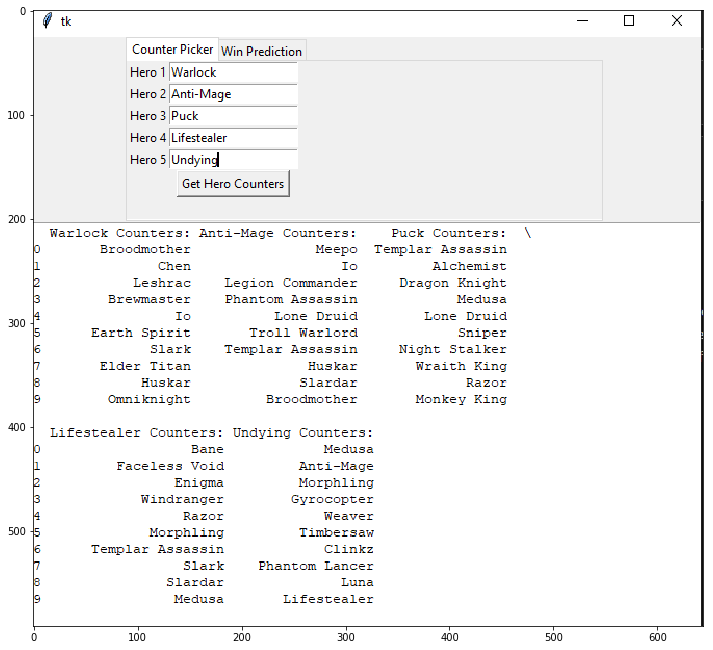

In [49]:
img1 = plt.imread('Hero Counters Snip.png')
plt.figure(figsize=(12,12))
plt.imshow(img1)

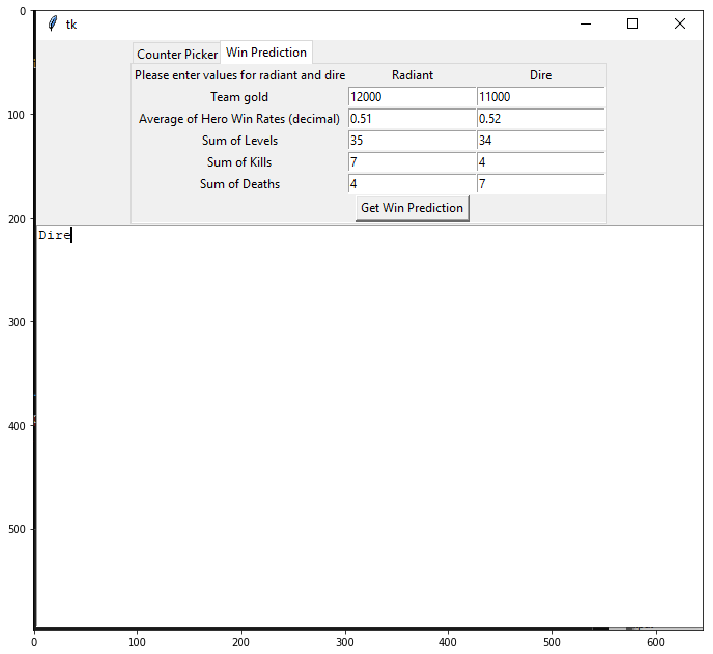

In [51]:
img2 = plt.imread('Win Prediction.png')
plt.figure(figsize=(12,12))
plt.imshow(img2)